In [1]:
from bs4 import BeautifulSoup
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import skimage
from skimage import data
from skimage.color import rgb2hsv
import pandas as pd
import random
import cv2
from PIL import ImageFile
from PIL import Image
from sklearn.cluster import KMeans
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
DATA_DIR = '../data/'
ARTIST_URL = 'https://www.wikiart.org/en/{artist}/all-works/text-list'
PAINTING_URL = 'https://www.wikiart.org{painting_path}'

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

artist_name = "pablo-picasso"
url_query = ARTIST_URL.format(artist=artist_name)
artist_page = requests.get(url_query)

# error handling
try:
    artist_page.raise_for_status()
except requests.exceptions.HTTPError as e:
    print("Error trying to retrieve {}".format(artist_page.url))
    raise e

# soup
soup = BeautifulSoup(artist_page.text, 'lxml')
IMAGE_DIR = os.path.join(DATA_DIR, artist_name)
if not os.path.exists(IMAGE_DIR):
    os.makedirs(IMAGE_DIR)
    
painting_paths = []

# retreive all rows in painting-list
for li in soup.find_all('li', {'class': 'painting-list-text-row'}):

    # retrieve all links in the current row
    for link in li.find_all('a'):
        href = link.get('href')
        # store in dictionary
        painting_paths.append(href)

print(len(painting_paths))

1160


In [17]:
dats = {}
def download_and_save(painting_url):
    r_painting_page = requests.get(painting_url)
    soup = BeautifulSoup(r_painting_page.text, 'lxml')
    datt = soup.find("span", itemprop="dateCreated")
    if datt is not None:
        datt = datt.text
    else:
        " "
    
    for img in soup.find_all('img', {'class': 'ms-zoom-cursor'}):
        img_url = img['src']
        img_url = img_url.split('!')[0]
        filename = img_url.split('/')[-1]

        dats[filename] = datt
        outfile = os.path.join(IMAGE_DIR, filename)                       
        if not os.path.exists(outfile):                        
            print("downloading {}: {}".format(filename, img_url))
            r = requests.get(img_url, outfile)
            with open(outfile, 'wb') as f:
                f.write(r.content)
        else:
            #print("skipping {}".format(filename))
            pass
        
for path in painting_paths:
    painting_path = PAINTING_URL.format(painting_path=path)
    download_and_save(painting_path)

In [24]:
np.mean(np.array([[1,2,3], [2,5,8], [3,4,5]]), axis=0)

array([2.        , 3.66666667, 5.33333333])

In [55]:
def calc_stats(f):
    camera = io.imread(f)
    mens = []
    for i in camera:
        mens.append(np.mean(i,axis=0))

    mens = np.array(mens)
    return np.append(np.mean(mens,axis=0), dats[f.split("\\")[-1]])



In [61]:
files = []
for r, d, f in os.walk(IMAGE_DIR):
    for file in f:
        if '.jpg' in file:
            files.append(os.path.join(r, file))

data = []
for f in files:
    try:
        data.append(calc_stats(f))
    except:
        print("Image " + f + "has not been processed")
    
df = pd.DataFrame(data).drop(4,axis=1).dropna()
df.head()

,0,1,2,3
0,157.1511816148059,154.8867764897295,83.34894447834047,1937
1,143.48283618581894,105.26995284666425,93.12982186517648,1937
2,140.11821295143216,149.4314570361146,133.7044209215442,1928
3,158.1823426573427,147.1066171328675,134.10973339160824,1930
4,143.1923788546255,155.1147977573088,166.92738085702854,1929


In [81]:
bools = (df[3] > "1900") & (df[3] < "1905")
ndf = df[bools]
obs = np.mean(ndf[2].astype(float) - ndf[1].astype(float) - ndf[0].astype(float))
ress = []
for i in range(500):
    ndf = df[np.random.permutation(bools)]
    ress.append(np.mean(ndf[2].astype(float) - ndf[1].astype(float) - ndf[0].astype(float)))
ress = np.array(ress)
np.mean(ress > obs)

0.0

In [4]:
def popart(camera, weird = False, blur = True, num = 1):
    reses = []
    shape = camera.shape
    tab = []
    for i in camera:
        for j in i:
            tab.append(j)

    tab = np.array(tab)
    df = pd.DataFrame(tab)

    km = KMeans(n_clusters = 3)
    km.fit(df)

    

    def sup1(x):
        if x["cl"] == 0:
            return [np.uint8((x[0] + cl0[0]) % 256), np.uint8((x[1] + cl0[1]) % 256), np.uint8((x[2] + cl0[2]) % 256)]

        if x["cl"] == 1:
            return [np.uint8((x[0] + cl1[0]) % 256), np.uint8((x[1] + cl1[1]) % 256), np.uint8((x[2] + cl1[2]) % 256)]

        return [np.uint8((x[0] + cl2[0]) % 256), np.uint8((x[1] + cl2[1]) % 256), np.uint8((x[2] + cl2[2]) % 256)]

    def sup2(x):
        if x["cl"] == 0:
            return cl0
        if x["cl"] == 1:
            return cl1

        return cl2

    df["cl"] = km.labels_
    
    
    for i in range(num):
        cl0 = [random.randint(0,255),random.randint(0,255),random.randint(0,255)]
        cl1 = [random.randint(0,255),random.randint(0,255),random.randint(0,255)]
        cl2 = [random.randint(0,255),random.randint(0,255),random.randint(0,255)]


        if weird:
            ndf = df.apply(func = sup2, axis = 1)
        else:
            ndf = df.apply(func = sup1, axis = 1)

        ncam = []
        for i in range(0, ndf.shape[0]-shape[1]+1, shape[1]):
            ncam.append(ndf.iloc[i:i+shape[1]])

        result = np.array(ncam, dtype = np.uint8)

        if blur:
            result = cv2.bilateralFilter(result,9,75,75)

        reses.append(result)
    
    return reses


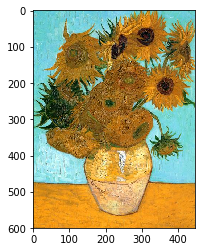

In [14]:
camera = io.imread("..\data\still-life-vase-with-twelve-sunflowers.jpg")
pop = popart(camera, weird = False, num=4)
plt.imshow(camera)
plt.show()

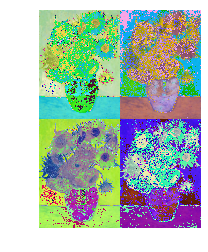

In [15]:
bg_color = (192,192,192)
widt = camera.shape[1]*2
heit = camera.shape[0]*2
figure = Image.new("RGB", (widt,heit), bg_color)
figure.paste(Image.fromarray(pop[0]), (0,0))
figure.paste(Image.fromarray(pop[1]), (camera.shape[1],0))
figure.paste(Image.fromarray(pop[2]), (0,camera.shape[0]))
figure.paste(Image.fromarray(pop[3]), (camera.shape[1],camera.shape[0]))
plt.imshow(figure)
plt.axis("off")
figure.show()

In [141]:
pop[3].shape

(550, 447, 3)

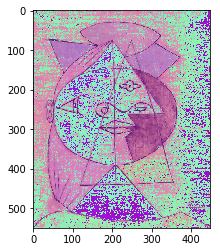

In [116]:
blur = cv2.bilateralFilter(ncam,9,75,75)
plt.figure()
plt.imshow(blur) 
plt.show()

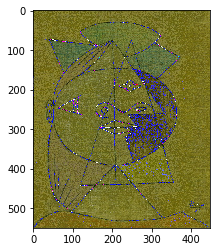

In [105]:
blur = cv2.bilateralFilter(img,9,75,75)